# Mel Filter Bank Implementation
The purpose of this notebook is to provide an implementation of a mel filter bank that can produce a Mel Spectrogram. The target runtime environment for this work is a Raspberry Pi embedded computer with an attached microphone.

References: 
* [Speech Processing for Machine Learning](http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

In [9]:
NFFT = 1024
CHUNK = 4*1024
CHANNELS = 1
RATE = 48000
RECORD_SECONDS = 3.5
WAVE_OUTPUT_FILENAME = "output.wav"

# Implementation of mel filter bank

In [33]:
"""PyAudio example: Record a few seconds of audio and save to a WAVE file."""

import numpy as np
import math

def melFilterBank(pow_frames,sample_rate=44100, nfilt=40, minHz=0, maxHz=0, normalize=True):
    low_freq_mel = minHz
    if(maxHz):
        high_freq_mel = freqToMel(maxHz)
    else:
        high_freq_mel = freqToMel(sample_rate / 2) #(2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = melToFreq(mel_points) #(700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    if(normalize):
        filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8) # normalise

    return (filter_banks,hz_points[1:-1]*2)

def freqToMel(freq):
    return (2595 * np.log10(1 + (freq / 2) / 700))

def melToFreq(mel):
    return (700 * (10**(mel / 2595) - 1))

def calc_mel(data, rate, NFFT = 1024, minHz=0, maxHz=8000, normalize=True):
    frame = list(bytearray(data)) # convert string representation of binary stream chunk into a byte array.
    frame *= np.hamming(len(frame))
    mag_frame = np.absolute(np.fft.rfft(frame, NFFT))  # Magnitude of the FFT
    pow_frame = ((1.0 / NFFT) * ((mag_frame) ** 2))  # Power Spectrum
    filterBanks = melFilterBank(pow_frame, sample_rate=rate, minHz=minHz, maxHz=maxHz, normalize=normalize) # MEL filter banks

    return filterBanks

# An artificial example using a generated 4khz sine wave
The purpose of this section is to visualise the various stages of the process of calculating the mel filter bank values for a single audio frame.

480
480


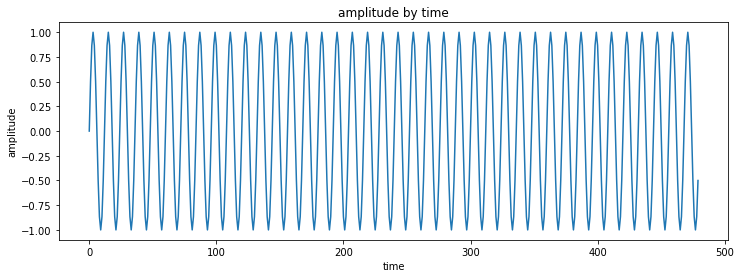

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

freq = 4000
frame_size_t = 0.01 # 10ms
window_size = frame_size_t * RATE
time = np.arange(0,frame_size_t,1/float(RATE))
data=np.sin(2*np.pi*4000*time)
print(len(time))
print(len(data))


from IPython.display import Audio
Audio(data, rate=RATE)
fig = plt.figure(figsize=(12,4))
plt.title('amplitude by time')
plt.ylabel('amplitude')
plt.xlabel('time')
plt.plot(data)
plt.show()

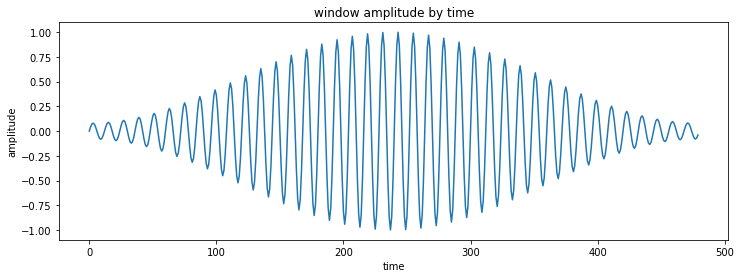

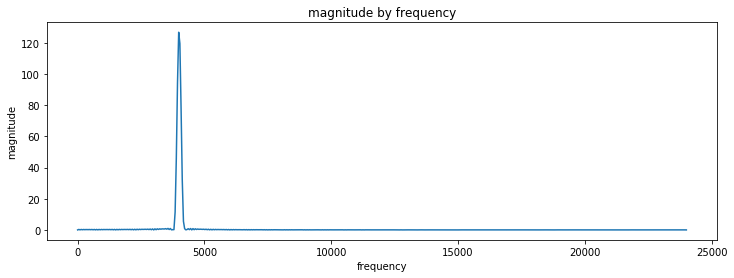

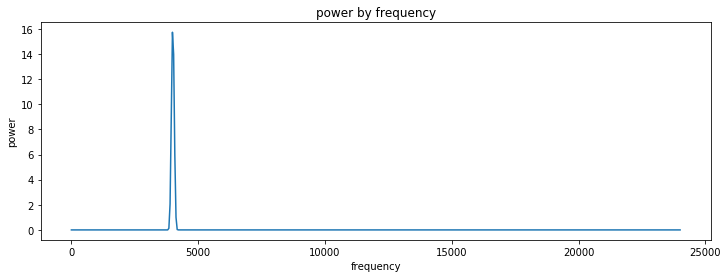

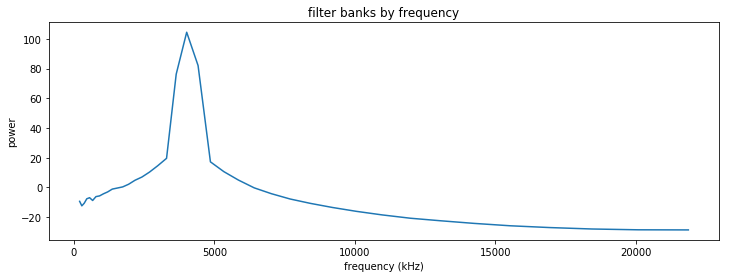

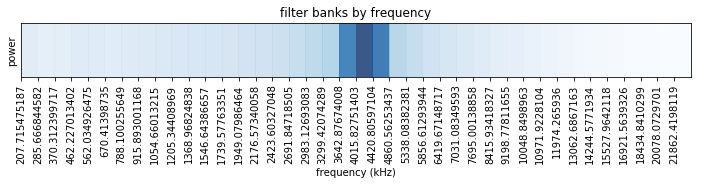

In [37]:
frame = data * np.hamming(len(data))

fig = plt.figure(figsize=(12,4))
plt.title('window amplitude by time')
plt.ylabel('amplitude')
plt.xlabel('time')
plt.plot(frame)
plt.show()

mag_frame = np.absolute(np.fft.rfft(frame, NFFT))  # Magnitude of the FFT
fig = plt.figure(figsize=(12,4))
freqs = np.linspace(0.0, RATE/2.0, len(mag_frame))
plt.title('magnitude by frequency')
plt.ylabel('magnitude')
plt.xlabel('frequency')
plt.plot(freqs,mag_frame)
plt.show()

pow_frame = ((1.0 / NFFT) * ((mag_frame) ** 2))  # Power Spectrum
fig = plt.figure(figsize=(12,4))
plt.title('power by frequency')
plt.ylabel('power')
plt.xlabel('frequency')
plt.plot(freqs,pow_frame)
plt.show()

filterBanks, hz_points = melFilterBank(pow_frame, minHz=200,maxHz=RATE, sample_rate=RATE) # MEL filter banks
fig = plt.figure(figsize=(12,4))
plt.title('filter banks by frequency')
plt.ylabel('power')
plt.xlabel('frequency (kHz)')
plt.plot(hz_points/2,filterBanks)
plt.show()

fig = plt.figure(figsize=(12,1))
plt.title('filter banks by frequency')
plt.ylabel('power')
plt.xlabel('frequency (kHz)')
plt.xticks(range(0,len(filterBanks)), hz_points/2, rotation='vertical')
plt.yticks([])
plt.pcolor(np.reshape(filterBanks,(1,40)), cmap=plt.cm.Blues, alpha=0.8)
plt.show()


# Perform analysis on realtime audio captured from a microphone
In this section a short recording is captured from the computers microphone. The mel filter bank analysis is performed on each audio chunk from the audio stream. The resulting recording is saved to disk so it can be analysed and the results compared to the realtime results.

In [38]:
import pyaudio
import wave

FORMAT = pyaudio.paInt16

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []
mels = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
    mel = calc_mel(data, RATE, minHz=200)
    mels.append(mel)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()
print ('length of mels: %i'%len(mels))

* recording
* done recording
length of mels: 38


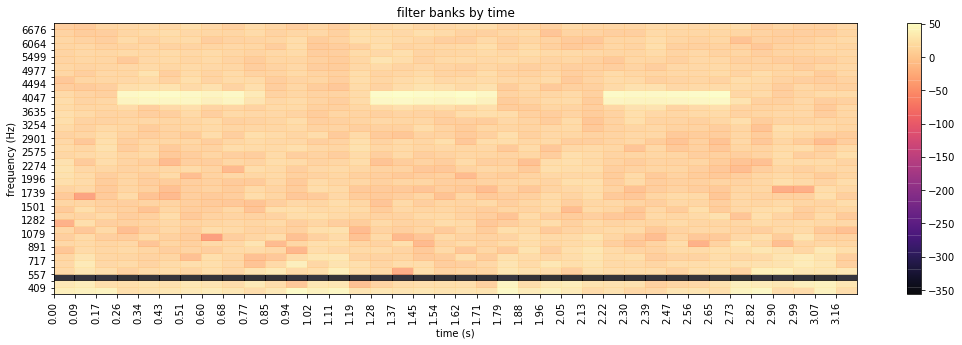

In [39]:
# select only the mel data ie. remove the freq labels
spec = np.array([mels[x][0] for x in range(0,len(mels))])

from matplotlib import ticker

fig = plt.figure(figsize=(18,5))
plt.title('filter banks by time')
plt.xlabel('time (s)')

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.set_xticks(ticks=range(0,len(spec)))
ax.set_xticklabels(["%0.2f"%(x*CHUNK/(float(RATE))) for x in range(0,len(spec))], rotation='vertical')

plt.ylabel('frequency (Hz)')
plt.yticks(range(0,len(spec[0])), mels[0][1])
ax.set_yticklabels(["%0.f"%(x) for x in mels[0][1]])
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.pcolor(spec.T, cmap=plt.cm.magma, alpha=0.8)

foo = ax.get_children()[0]
plt.colorbar(foo, ax=ax)
plt.show()

# Use librosa to create a melspectrogram for comparison

(155648,)


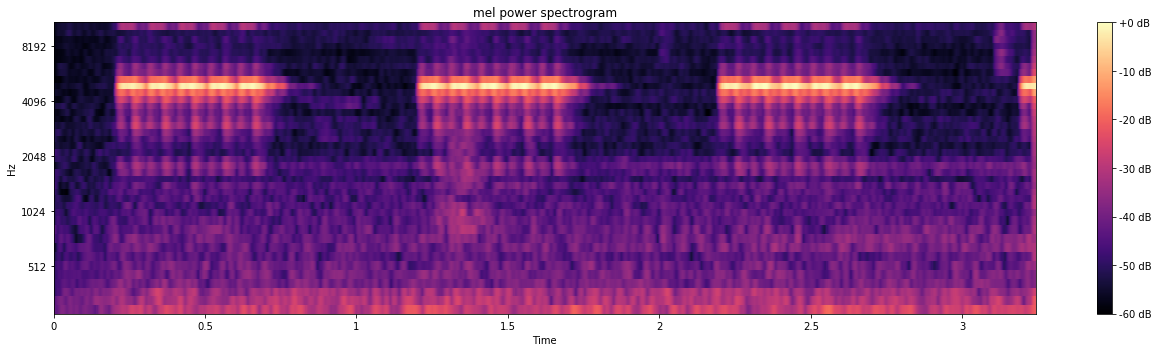

In [40]:
import librosa
import librosa.display
x, sr = librosa.load(WAVE_OUTPUT_FILENAME, sr=None)
print x.shape
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(x, sr=sr, n_mels=40, fmin=200, fmax=8000, hop_length=160)

# Convert to log scale (dB). We'll use the peak power as reference.
log_S = librosa.logamplitude(S, ref_power=np.max)

# Make a new figure
plt.figure(figsize=(18,5))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, x_axis='time', sr=sr, y_axis='mel', hop_length=160)

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()
plt.show()
